### Summarize and aggregate susceptibility scores across all queries

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

from preprocessing.datasets import CountryCapital
from susceptibility_scores import construct_paths_and_dataset_kwargs

/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cluster/home/kevidu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/scratch/tmp.49332200.kevidu/ipykernel_11599/3433351704.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pand

In [3]:
!pwd

/cluster/work/cotterell/kdu/measureLM


In [4]:
# import matplotlib as mpl

# # Plot formatting
# mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["axes.spines.right"] = False
# mpl.rcParams["axes.spines.top"] = False
# plt.rcParams["axes.facecolor"] = "white"
# plt.rcParams["savefig.facecolor"] = "white"
# # plt.rcParams["text.usetex"] = True
# # plt.rcParams["font.family"] = "serif"
# # plt.rcParams["font.serif"] = "Computer Modern Serif"

# # try:
# #     # Set the font properties globally
# #     font_path = "./fonts/cmunbx.otf"
# #     font_prop = fm.FontProperties(fname=font_path, size=12)
# #     print(font_prop.get_name())
# #     plt.rc("font", family=font_prop.get_name())
# # except:
# #     print("Unable to set font to Computer Modern (cmunbx.otf)")

# font = {
#     # "family": "normal",
#     # "weight": "bold",
#     "size": 22,
# }
# plt.rc("font", **font)

In [5]:
# # palette = sns.color_palette("Set2", 5)
# palette = sns.color_palette("colorblind", 5)
# palette = palette[2:4]
# sns.set_palette(palette)

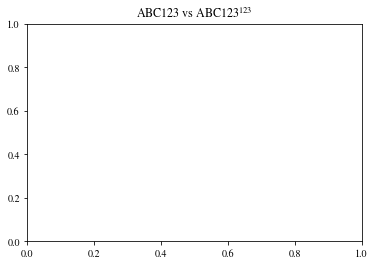

In [6]:
import matplotlib

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"
matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")


matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind", 5)[2:4]
sns.set_palette(palette)

In [7]:
##################
### Parameters ###
##################

# Data parameters
DATASET_NAME = "YagoECQ"
RAW_DATA_PATH = "data/YagoECQ/yago_qec.json"
SEED = 0
MODEL_ID = "EleutherAI/pythia-6.9b-deduped"
LOAD_IN_8BIT = True
MAX_CONTEXTS = 500
MAX_ENTITIES = 100
CAP_PER_TYPE = False
ABLATE_OUT_RELEVANT_CONTEXTS = False
UNIFORM_CONTEXTS = True
DEDUPLICATE_ENTITIES = True
# ENTITY_SELECTION_FUNC_NAME = "random_sample"
ENTITY_SELECTION_FUNC_NAME = "top_entity_uri_degree"
# ENTITY_SELECTION_FUNC_NAME = "top_entity_namesake_degree"

OVERWRITE = True
ENTITY_TYPES = ["entities", "gpt_fake_entities"]
# ENTITY_TYPES = ["entities", "fake_entities"]
QUERY_TYPES = ["closed", "open"]
# QUERY_TYPES = ["closed"]
# ANSWER_MAP = {
#     0: [1621, 642, 7651, 2302, 2369, 7716],
#     1: [6279, 4754, 22487, 4374, 9820, 24239],
# }
ANSWER_MAP = None

# Model parameters
BATCH_SZ = 16

# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [8]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [9]:
query_ids = list(yago_qec.keys())

In [10]:
analysis_dir = "analysis/summarize/"
os.makedirs(analysis_dir, exist_ok=True)

In [11]:
dataset_names_and_rdps = [("YagoECQ", RAW_DATA_PATH)]
seeds = [1, 3, 4]
model_id_and_quantize_tuples = [("EleutherAI/pythia-6.9b-deduped", True)]
max_contexts = [500]
max_entities = [100]
query_ids = list(yago_qec.keys())
# query_ids = ["http://schema.org/founder"]

ent_selection_fns = [
    "top_entity_uri_degree",
    "top_entity_namesake_degree",
    "random_sample",
]

# entity_types = json.dumps(
#     ["entities", "fake_entities"], separators=(",", ":")
# )  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
entity_types = json.dumps(
    ["entities", "gpt_fake_entities"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
# query_types = json.dumps(
#     ["closed", "open"], separators=(",", ":")
# )  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.
query_types = json.dumps(
    ["closed", "open"], separators=(",", ":")
)  # separators is important to remove spaces from the string. This is important downstream for bash to be able to read the whole list.

answer_map = dict()
# answer_map = {0: [" No", " no", " NO", "No", "no", "NO"], 1: [" Yes", " yes", " YES", "Yes", "yes", "YES"]}

cap_per_type = False
ablate = False
deduplicate_entities = True
uniform_contexts = True
overwrite = False


def convert_answer_map_to_tokens(
    model_id: str, answer_map: Dict[int, List[str]]
) -> str:
    tokenizer = AutoTokenizer.from_pretrained(
        model_id,
        padding_side="left",
    )

    answer_map_token_ids = dict()
    for k, v in answer_map.items():
        list_of_token_ids: List[List[str]] = tokenizer(v)["input_ids"]
        valid_token_ids = []
        for token_id in list_of_token_ids:
            if len(token_id) == 1:
                valid_token_ids.append(token_id[0])
            else:
                print(
                    f"tokenizer tokenized an answer map token into multiple tokens ({token_id}), which is invalid input."
                )
        answer_map_token_ids[k] = valid_token_ids
    #     answer_map_token_ids = {
    #         k: [x[0] for x in tokenizer(v)["input_ids"] if len(x) == 1],
    #         for k, v in answer_map.items()
    #     }
    res = json.dumps(answer_map_token_ids, separators=(",", ":"))
    print(res)
    return res


df_dict = []
for ds, rdp in dataset_names_and_rdps:
    for seed in seeds:
        for model_id, do_quantize in model_id_and_quantize_tuples:
            answer_map_in_tokens = convert_answer_map_to_tokens(model_id, answer_map)
            for qid in query_ids:
                for mc in max_contexts:
                    for me in max_entities:
                        for es in ent_selection_fns:
                            dict_vals = dict(
                                DATASET_NAME=ds,
                                RAW_DATA_PATH=rdp,
                                SEED=seed,
                                MODEL_ID=model_id,
                                LOAD_IN_8BIT=do_quantize,
                                QUERY_ID=qid,
                                MAX_CONTEXTS=mc,
                                MAX_ENTITIES=me,
                                CAP_PER_TYPE=cap_per_type,
                                ABLATE_OUT_RELEVANT_CONTEXTS=ablate,
                                DEDUPLICATE_ENTITIES=deduplicate_entities,
                                UNIFORM_CONTEXTS=uniform_contexts,
                                ENTITY_SELECTION_FUNC_NAME=es,
                                OVERWRITE=overwrite,
                                ENTITY_TYPES=json.loads(entity_types),
                                QUERY_TYPES=json.loads(query_types),
                                ANSWER_MAP=json.loads(answer_map_in_tokens)
                                if json.loads(answer_map_in_tokens)
                                else None,
                            )
                            (
                                data_dir,
                                input_dir,
                                entities_path,
                                contexts_path,
                                queries_path,
                                answers_path,
                                val_data_path,
                                model_dir,
                                results_dir,
                                val_results_path,
                                data_id,
                                _,
                                DATASET_KWARGS_IDENTIFIABLE,
                            ) = construct_paths_and_dataset_kwargs(**dict_vals)
                            if os.path.isfile(val_results_path):
                                res = pd.read_csv(
                                    val_results_path,
                                    index_col=0,
                                    converters={
                                        # "contexts": literal_eval,
                                        "entity": literal_eval,
                                    },
                                )
                                closed_qfs = yago_qec[qid]["query_forms"]["closed"]
                                open_qfs = yago_qec[qid]["query_forms"]["open"]

                                res.loc[
                                    res["query_form"].isin(closed_qfs), "query_type"
                                ] = "closed"
                                res.loc[
                                    res["query_form"].isin(open_qfs), "query_type"
                                ] = "open"
                                res.loc[
                                    res["entity"].isin(
                                        [
                                            (x,)
                                            for x in yago_qec[qid]["gpt_fake_entities"]
                                        ]
                                    ),
                                    "entity_type",
                                ] = "gpt_fake_entities"
                                res.loc[
                                    res["entity"].isin(
                                        [(x,) for x in yago_qec[qid]["entities"]]
                                    ),
                                    "entity_type",
                                ] = "entities"
                                res["entity_classes"] = res["q_id"].apply(
                                    lambda x: yago_qec[qid]["entity_types"]
                                )
                                res["entity"] = res["entity"].apply(lambda x: x[0])
                                scores: List[dict] = res[
                                    [
                                        "entity",
                                        "answer",
                                        "query_form",
                                        "entity_type",
                                        "query_type",
                                        "entity_classes",
                                        "susceptibility_score",
                                        "contexts",
                                        "persuasion_scores",
                                    ]
                                ].to_dict("records")
                                df_dict += [{**dict_vals, **d} for d in scores]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{}


In [12]:
scores_df = pd.DataFrame(df_dict)
scores_df.to_csv("summarized_scores.csv", index=False)
scores_df["ENTITY_TYPES"] = scores_df["ENTITY_TYPES"].apply(lambda x: tuple(x))
scores_df["QUERY_TYPES"] = scores_df["QUERY_TYPES"].apply(lambda x: tuple(x))
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146908 entries, 0 to 146907
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   DATASET_NAME                  146908 non-null  object 
 1   RAW_DATA_PATH                 146908 non-null  object 
 2   SEED                          146908 non-null  int64  
 3   MODEL_ID                      146908 non-null  object 
 4   LOAD_IN_8BIT                  146908 non-null  bool   
 5   QUERY_ID                      146908 non-null  object 
 6   MAX_CONTEXTS                  146908 non-null  int64  
 7   MAX_ENTITIES                  146908 non-null  int64  
 8   CAP_PER_TYPE                  146908 non-null  bool   
 9   ABLATE_OUT_RELEVANT_CONTEXTS  146908 non-null  bool   
 10  DEDUPLICATE_ENTITIES          146908 non-null  bool   
 11  UNIFORM_CONTEXTS              146908 non-null  bool   
 12  ENTITY_SELECTION_FUNC_NAME    146908 non-nul

### Variance of susceptibility scores

In [13]:
# Get scores df for vesteinn to analyze the diff in sus score against the entity frequency
scores_df_vesteinn = scores_df[(scores_df["SEED"] == 1)][
    ["QUERY_ID", "query_form", "entity_type", "query_type", "susceptibility_score"]
]
scores_df_vesteinn.to_csv("sus_scores_real_and_fake_ents.csv")

In [14]:
scores_df.groupby(["QUERY_ID", "entity", "query_type"]).agg(
    {"susceptibility_score": "var"}
).dropna()
# Higher variance for open questions because the "A is ..." tends to differ from the "What's the {} of entity?"

susceptibility_score
QUERY_ID                                           entity                  query_type                      
http://schema.org/about                            A Christmas Carol       closed                  0.000005
                                                                           open                    0.187867
                                                   A Labyrinth of Citrines closed                  0.000011
                                                                           open                    0.370777
                                                   A Very Long Engagement  closed                  0.000019
...                                                                                                     ...
reverse-http://yago-knowledge.org/resource/term... Zephyr Vale             open                    1.251912
                                                   Zephyr's Reach          closed                  0.000079
                                                                           open                    1.050165
                                                   Zion Zephyrlands        closed                  0.000019
                                                                           open                    0.714251

[45845 rows x 1 columns]

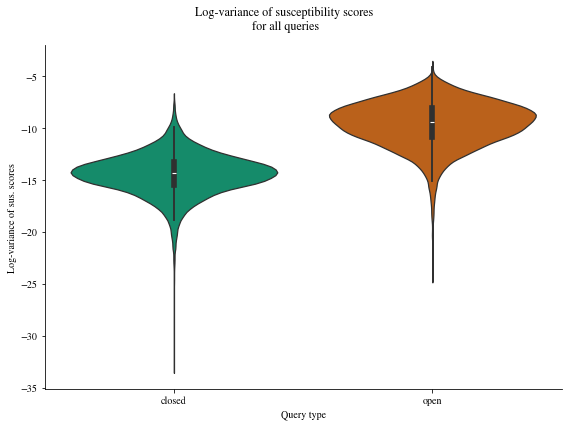

In [15]:
sus_score_var_df = (
    scores_df.groupby(["QUERY_ID", "entity", "query_type", "query_form"])
    .agg(sus_score_var=("susceptibility_score", "var"))
    .dropna()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 6))
sus_score_var_df["log_sus_score_var"] = sus_score_var_df["sus_score_var"].apply(np.log)
sus_score_var_df
sns.violinplot(
    sus_score_var_df,
    y="log_sus_score_var",
    x="query_type",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
    ax=ax,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of sus. scores")
# ax.set_ylim((-35, -2))
fig.suptitle("Log-variance of susceptibility scores\n for all queries")
plt.tight_layout()

plot_name = f"plot_susscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Variance of persuasion scores

In [16]:
# Reliability/variance of persuasion scores
scores_df["contexts"] = scores_df["contexts"].apply(literal_eval)

In [17]:
from tqdm import tqdm

tqdm.pandas()
scores_df["persuasion_scores"] = scores_df["persuasion_scores"].progress_apply(
    literal_eval
)

100%|██████████| 146908/146908 [03:30<00:00, 697.65it/s] 


In [18]:
scores_df.head()

,DATASET_NAME,RAW_DATA_PATH,SEED,MODEL_ID,LOAD_IN_8BIT,QUERY_ID,MAX_CONTEXTS,MAX_ENTITIES,CAP_PER_TYPE,ABLATE_OUT_RELEVANT_CONTEXTS,...,ANSWER_MAP,entity,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores
0,YagoECQ,data/YagoECQ/yago_qec.json,1,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/highestPoint,500,100,False,False,...,None,India,Kanchenjunga,Q: Is {entity}'s highest point {answer}?\nA:,entities,closed,"[http://schema.org/Place, http://schema.org/Or...",0.025624,[The highest point of Acumen Alliance is Mount...,"[0.028884888, 0.17391515, 0.071145296, 0.07855..."
1,YagoECQ,data/YagoECQ/yago_qec.json,1,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/highestPoint,500,100,False,False,...,None,Germany,Zugspitze,Q: Is {entity}'s highest point {answer}?\nA:,entities,closed,"[http://schema.org/Place, http://schema.org/Or...",0.026738,[The highest point of Acumen Alliance is Mount...,"[-0.033174515, 0.15923643, 0.027595282, -0.014..."
2,YagoECQ,data/YagoECQ/yago_qec.json,1,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/highestPoint,500,100,False,False,...,None,Japan,Mount Fuji,Q: Is {entity}'s highest point {answer}?\nA:,entities,closed,"[http://schema.org/Place, http://schema.org/Or...",0.030305,[The highest point of Acumen Alliance is Mount...,"[0.012548685, -0.014935732, -0.019042253, 0.03..."
3,YagoECQ,data/YagoECQ/yago_qec.json,1,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/highestPoint,500,100,False,False,...,None,London,Biggin Hill,Q: Is {entity}'s highest point {answer}?\nA:,entities,closed,"[http://schema.org/Place, http://schema.org/Or...",0.029309,[The highest point of Acumen Alliance is Mount...,"[-0.12189889, 0.17194843, 0.116350174, 0.10433..."
4,YagoECQ,data/YagoECQ/yago_qec.json,1,EleutherAI/pythia-6.9b-deduped,True,http://schema.org/highestPoint,500,100,False,False,...,None,Argentina,Aconcagua,Q: Is {entity}'s highest point {answer}?\nA:,entities,closed,"[http://schema.org/Place, http://schema.org/Or...",0.029557,[The highest point of Acumen Alliance is Mount...,"[0.040514946, 0.046737194, 0.057446957, -0.048..."


In [19]:
from functools import reduce

# Define a custom aggregation function for intersection
def intersection_aggregate(x):
    # Take the intersection of all sets in the group
    return reduce(lambda a, b: set(a).intersection(set(b)), x)

In [20]:
# Function to filter rows
def filter_rows_by_unique_values(dataframe, column_name, unique_count):
    # Group by the specified column and filter
    filtered_df = dataframe.groupby(column_name).filter(
        lambda x: x["SEED"].nunique() == unique_count
    )
    return filtered_df


# Applying the function
filtered_df = filter_rows_by_unique_values(
    scores_df, ["QUERY_ID", "entity", "query_form", "query_type"], 3
)
filtered_df["contexts"] = filtered_df["contexts"].progress_apply(tuple)
filtered_df["persuasion_scores"] = filtered_df["persuasion_scores"].progress_apply(
    tuple
)
filtered_df["entity_classes"] = filtered_df["entity_classes"].progress_apply(tuple)
filtered_df = filtered_df.drop_duplicates()

100%|██████████| 72902/72902 [00:00<00:00, 1442217.33it/s]


In [21]:
set(
    filtered_df[["QUERY_ID", "entity", "query_form", "query_type"]].value_counts()
)  # this should be just 3

{3}

In [22]:
overlapping_contexts_df = (
    filtered_df.groupby(["QUERY_ID", "entity"]).agg(
        shared_contexts=("contexts", intersection_aggregate)
    )
    # .to_frame()
    .reset_index()
)
overlapping_contexts_df = overlapping_contexts_df[
    overlapping_contexts_df["shared_contexts"] != set()
]
overlapping_contexts_df["shared_contexts"] = overlapping_contexts_df[
    "shared_contexts"
].progress_apply(tuple)
overlapping_contexts_df

100%|██████████| 1505/1505 [00:00<00:00, 292539.97it/s]


,QUERY_ID,entity,shared_contexts
500,http://schema.org/contentLocation,A Midsummer Night's Dream,"('Godzilla' takes place in London.\n, 'Jessie'..."
501,http://schema.org/contentLocation,Ace Ventura: Pet Detective,"('Godzilla' takes place in London.\n, 'Jessie'..."
502,http://schema.org/contentLocation,Amélie,"('Godzilla' takes place in London.\n, 'Jessie'..."
503,http://schema.org/contentLocation,Argo,"('Godzilla' takes place in London.\n, 'Jessie'..."
504,http://schema.org/contentLocation,Brokeback Mountain,"('Godzilla' takes place in London.\n, 'Jessie'..."
...,...,...,...
5605,reverse-http://yago-knowledge.org/resource/dir...,Vladimir Spivakov,(Vladimir Spivakov has directed The Velvet Und...
5606,reverse-http://yago-knowledge.org/resource/dir...,Vytautas Miškinis,(Vladimir Spivakov has directed The Velvet Und...
5607,reverse-http://yago-knowledge.org/resource/dir...,Wiktoria Zalewska,(Vladimir Spivakov has directed The Velvet Und...
5608,reverse-http://yago-knowledge.org/resource/dir...,Yuri Simonov,(Vladimir Spivakov has directed The Velvet Und...


In [23]:
overlapping_contexts_filtered_df = overlapping_contexts_df.merge(
    filtered_df, on=["QUERY_ID", "entity"], how="inner"
)
overlapping_contexts_filtered_df = overlapping_contexts_filtered_df.loc[
    :, overlapping_contexts_filtered_df.nunique() > 1
]

In [24]:
exploded_overlapping_contexts_filtered_df = overlapping_contexts_filtered_df.explode(
    "shared_contexts"
)
set(
    exploded_overlapping_contexts_filtered_df[
        ["QUERY_ID", "entity", "shared_contexts", "query_form"]
    ].value_counts()
)  # should just be {3} still

{3}

In [25]:
exploded_overlapping_contexts_filtered_df

,QUERY_ID,entity,shared_contexts,SEED,answer,query_form,entity_type,query_type,entity_classes,susceptibility_score,contexts,persuasion_scores
0,http://schema.org/contentLocation,A Midsummer Night's Dream,'Godzilla' takes place in London.\n,1,Athens,Q: Does '{entity}' take place in {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.015161,('A Dirge for the Drowned' takes place in Mary...,"(0.11858988, 0.18953371, 0.16972399, 0.0476374..."
0,http://schema.org/contentLocation,A Midsummer Night's Dream,"'Jessie' takes place in Washington, D.C..\n",1,Athens,Q: Does '{entity}' take place in {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.015161,('A Dirge for the Drowned' takes place in Mary...,"(0.11858988, 0.18953371, 0.16972399, 0.0476374..."
0,http://schema.org/contentLocation,A Midsummer Night's Dream,'Kill Bill Volume 1' takes place in London.\n,1,Athens,Q: Does '{entity}' take place in {answer}?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.015161,('A Dirge for the Drowned' takes place in Mary...,"(0.11858988, 0.18953371, 0.16972399, 0.0476374..."
1,http://schema.org/contentLocation,A Midsummer Night's Dream,'Godzilla' takes place in London.\n,1,Athens,Q: IS {answer} the setting of '{entity}'?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.021823,('A Dirge for the Drowned' takes place in Mary...,"(0.071178675, 0.056360006, 0.07391977, 0.13507..."
1,http://schema.org/contentLocation,A Midsummer Night's Dream,"'Jessie' takes place in Washington, D.C..\n",1,Athens,Q: IS {answer} the setting of '{entity}'?\nA:,entities,closed,"(http://schema.org/CreativeWork, http://schema...",0.021823,('A Dirge for the Drowned' takes place in Mary...,"(0.071178675, 0.056360006, 0.07391977, 0.13507..."
...,...,...,...,...,...,...,...,...,...,...,...,...
17929,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Vladimir Spivakov has directed The Velvet Unde...,3,Saint Petersburg Philharmonic Orchestra,{entity} has directed,entities,open,"(http://schema.org/Person,)",0.648472,(Alexander Vasilyevich Alexandrov has directed...,"(0.9711809, 1.4197493, -0.06941652, -0.0589351..."
17930,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Vladimir Spivakov has directed The Velvet Unde...,4,Saint Petersburg Philharmonic Orchestra,Q: Was {answer} ever directed by {entity}?\nA:,entities,closed,"(http://schema.org/Person,)",0.018981,(Afreen Malik has directed Southern Syncopated...,"(0.075927496, 0.07339764, -0.16976523, 0.07612..."
17931,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Vladimir Spivakov has directed The Velvet Unde...,4,Saint Petersburg Philharmonic Orchestra,Q: Did {entity} ever direct {answer}?\nA:,entities,closed,"(http://schema.org/Person,)",0.015488,(Afreen Malik has directed Southern Syncopated...,"(0.0037066936, 0.10402942, 0.06649041, 0.00548..."
17932,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Vladimir Spivakov has directed The Velvet Unde...,4,Saint Petersburg Philharmonic Orchestra,Q: What has {entity} been a director of?\nA:,entities,open,"(http://schema.org/Person,)",0.198252,(Afreen Malik has directed Southern Syncopated...,"(0.08627176, -0.022749424, 0.18778992, 0.27926..."


In [26]:
row = exploded_overlapping_contexts_filtered_df.iloc[0]


def get_p_score_for_shared_context(row: pd.Series):
    shared_context_ind = list(row["contexts"]).index(row["shared_contexts"])
    p_score_for_shared_context = row["persuasion_scores"][shared_context_ind]
    return p_score_for_shared_context

In [27]:
exploded_overlapping_contexts_filtered_df[
    "p_score"
] = exploded_overlapping_contexts_filtered_df.progress_apply(
    get_p_score_for_shared_context, axis=1
)

100%|██████████| 338514/338514 [00:04<00:00, 79125.32it/s]


In [28]:
var_pscore_df = (
    exploded_overlapping_contexts_filtered_df.groupby(
        ["QUERY_ID", "entity", "query_form", "query_type", "shared_contexts"]
    )
    .agg(var_p_score=("p_score", "var"))
    .reset_index()
)
var_pscore_df["log_var_p_score"] = var_pscore_df["var_p_score"].progress_apply(np.log)

100%|██████████| 112838/112838 [00:00<00:00, 729310.97it/s]


In [29]:
sns.color_palette("Set2", 5)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

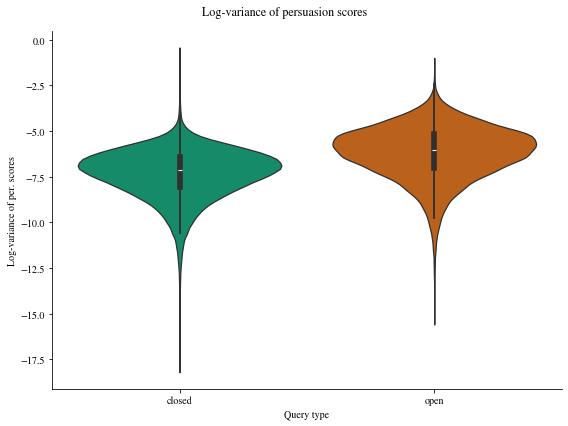

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=var_pscore_df,
    x="query_type",
    y="log_var_p_score",
    hue="query_type",
    order=sorted(sus_score_var_df["query_type"].unique()),
    hue_order=sorted(sus_score_var_df["query_type"].unique()),
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance of per. scores")
fig.suptitle("Log-variance of persuasion scores")
plt.tight_layout()

plot_name = f"plot_persuasionscore_variance_across_all_queries_closed_vs_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### One plot

In [31]:
var_pscore_df["log_var"] = var_pscore_df["log_var_p_score"]
var_pscore_df["score_type"] = "p_score"
var_pscore_df

,QUERY_ID,entity,query_form,query_type,shared_contexts,var_p_score,log_var_p_score,log_var,score_type
0,http://schema.org/contentLocation,A Midsummer Night's Dream,'{entity}' takes place in,open,'Godzilla' takes place in London.\n,0.003107,-5.774091,-5.774091,p_score
1,http://schema.org/contentLocation,A Midsummer Night's Dream,'{entity}' takes place in,open,"'Jessie' takes place in Washington, D.C..\n",0.008488,-4.769141,-4.769141,p_score
2,http://schema.org/contentLocation,A Midsummer Night's Dream,'{entity}' takes place in,open,'Kill Bill Volume 1' takes place in London.\n,0.003783,-5.577243,-5.577243,p_score
3,http://schema.org/contentLocation,A Midsummer Night's Dream,Q: Does '{entity}' take place in {answer}?\nA:,closed,'Godzilla' takes place in London.\n,0.002358,-6.049904,-6.049904,p_score
4,http://schema.org/contentLocation,A Midsummer Night's Dream,Q: Does '{entity}' take place in {answer}?\nA:,closed,"'Jessie' takes place in Washington, D.C..\n",0.000555,-7.496890,-7.496890,p_score
...,...,...,...,...,...,...,...,...,...
112833,reverse-http://yago-knowledge.org/resource/dir...,Yuri Simonov,{entity} has directed,open,Vladimir Spivakov has directed The Velvet Unde...,0.004386,-5.429240,-5.429240,p_score
112834,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Q: Did {entity} ever direct {answer}?\nA:,closed,Vladimir Spivakov has directed The Velvet Unde...,0.001607,-6.433444,-6.433444,p_score
112835,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Q: Was {answer} ever directed by {entity}?\nA:,closed,Vladimir Spivakov has directed The Velvet Unde...,0.000207,-8.481815,-8.481815,p_score
112836,reverse-http://yago-knowledge.org/resource/dir...,Yuri Temirkanov,Q: What has {entity} been a director of?\nA:,open,Vladimir Spivakov has directed The Velvet Unde...,0.000875,-7.041179,-7.041179,p_score


In [32]:
sus_score_var_df["log_var"] = sus_score_var_df["log_sus_score_var"]
sus_score_var_df["score_type"] = "sus_score"
sus_score_var_df

,QUERY_ID,entity,query_type,query_form,sus_score_var,log_sus_score_var,log_var,score_type
0,http://schema.org/about,A Christmas Carol,closed,Q: Does {answer} pertain to '{entity}'?\nA:,2.152230e-06,-13.049006,-13.049006,sus_score
1,http://schema.org/about,A Christmas Carol,closed,Q: Is '{entity}' about {answer}?\nA:,3.224393e-06,-12.644766,-12.644766,sus_score
2,http://schema.org/about,A Christmas Carol,open,'{entity}' is about,4.235748e-03,-5.464195,-5.464195,sus_score
3,http://schema.org/about,A Christmas Carol,open,Q: What is '{entity}' about?\nA:,3.860870e-05,-10.162033,-10.162033,sus_score
4,http://schema.org/about,A Very Long Engagement,closed,Q: Does {answer} pertain to '{entity}'?\nA:,6.286360e-06,-11.977128,-11.977128,sus_score
...,...,...,...,...,...,...,...,...
30484,reverse-http://yago-knowledge.org/resource/ter...,"Washington, D.C.",open,{entity} is the terminus of,1.280371e-04,-8.963190,-8.963190,sus_score
30485,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,closed,Q: Is the terminus of {answer} {entity}?\nA:,2.770371e-06,-12.796529,-12.796529,sus_score
30486,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,closed,Q: Is {entity} the terminus of {answer}?\nA:,5.098576e-07,-14.489134,-14.489134,sus_score
30487,reverse-http://yago-knowledge.org/resource/ter...,West Virginia,open,Q: What is {entity} the terminus of?\nA:,2.221473e-04,-8.412170,-8.412170,sus_score


In [33]:
shared_cols = set(sus_score_var_df.columns).intersection(var_pscore_df.columns)
combined_df = pd.concat([sus_score_var_df, var_pscore_df[shared_cols]], axis=0)
combined_df

TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [ ]:
sorted(sus_score_var_df["score_type"].unique())

In [ ]:
palette = sns.color_palette("colorblind", 5)
sns.set_palette(palette)
fig, ax = plt.subplots(figsize=(8, 6))
sns.violinplot(
    data=combined_df,
    x="query_type",
    y="log_var",
    hue="score_type",
    dodge=True,
    order=sorted(combined_df["query_type"].unique()),
    hue_order=reversed(sorted(combined_df["score_type"].unique())),
    legend=None,
)
ax.set_xlabel("Query type")
ax.set_ylabel("Log-variance")
ax.set_title("Log-variance of susceptibility\nand persuasion scores")
# fig.suptitle("Log-variance of sus. and per. scores")
plt.tight_layout()

plot_name = f"plot_variance_both_scores"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Scratch

In [ ]:
# SUS scores
qid = "http://schema.org/lyricist"
query_form = scores_df[scores_df["QUERY_ID"] == qid]["query_form"].unique()[0]
qid_df = scores_df[(scores_df["QUERY_ID"] == qid)][
    ["SEED", "entity", "query_form", "susceptibility_score"]
]

qid_qf_df = qid_df[qid_df["query_form"] == query_form]
qid_qf_df

In [32]:
qid_df.groupby(["entity", "query_form"]).agg({"susceptibility_score": "var"}).dropna()

susceptibility_score
entity              query_form                                                              
Across the Universe A lyricist for '{entity}' is a                              2.764812e-03
                    Q: Does '{entity}' credit {answer} as a lyricis...          1.050001e-07
                    Q: Is {answer} a lyricist for '{entity}'?\nA:               3.400066e-07
                    Q: Who is a lyricist for '{entity}'?\nA:                    7.002364e-06
Amazing Grace       A lyricist for '{entity}' is a                              1.680540e-03
...                                                                                      ...
Wish You Were Here  Q: Who is a lyricist for '{entity}'?\nA:                    9.334569e-05
Your Song           A lyricist for '{entity}' is a                              3.432307e-03
                    Q: Does '{entity}' credit {answer} as a lyricis...          5.796439e-08
                    Q: Is {answer} a lyricist for '{entity}'?\nA:               1.174609e-06
                    Q: Who is a lyricist for '{entity}'?\nA:                    1.132283e-04

[236 rows x 1 columns]

In [33]:
# Persuasion scores
overlapping_contexts_filtered_df[
    (
        overlapping_contexts_filtered_df["QUERY_ID"]
        == "http://schema.org/contentLocation"
    )
    & (overlapping_contexts_filtered_df["entity"] == "A Midsummer Night's Dream")
    & (overlapping_contexts_filtered_df["query_form"] == "'{entity}' takes place in")
]["contexts"]

3     ('A Dirge for the Drowned' takes place in Mary...
7     ('A Midsummer Night's Dream' takes place in Ne...
11    ('A Midsummer Night's Dream' takes place in Ne...
Name: contexts, dtype: object